<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Notes/Load_CSV_Using_tf_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/load_data/csv

If you need more control over the input data pipeline or need to use data that doesn't easily fit into memory: use `tf.data`.



In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import pathlib
import os
import re
import matplotlib.pyplot as plt


from datetime import datetime

In [2]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
# features and labels
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

In [4]:
titanic_feature_dict = {k:np.array(v) for k,v in titanic_features.items()}

In [5]:
# manually slice up the dictionary of features 

def slice_features(feature_dict):
  for i in itertools.count():
    yield {k: v[i] for k,v in feature_dict.items()}

In [6]:
for row in slice_features(titanic_feature_dict):
  for k, v in row.items():
    print(f'{k:20} {v}')
  break

sex                  male
age                  22.0
n_siblings_spouses   1
parch                0
fare                 7.25
class                Third
deck                 unknown
embark_town          Southampton
alone                n


The most basic `tf.data.Dataset` **in memory data loader** is the `Dataset.from_tensor_slices` constructor. This returns a `tf.data.Dataset` that implements a generalized version of the above slices function, in TensorFlow.

In [7]:
titanic_feature_ds = tf.data.Dataset.from_tensor_slices((dict(titanic_features), titanic_labels))

In [8]:
for feat_dict, label in titanic_feature_ds:
  for k,v in feat_dict.items():
    print(f'{k:20} {v}')
  break

sex                  b'male'
age                  22.0
n_siblings_spouses   1
parch                0
fare                 7.25
class                b'Third'
deck                 b'unknown'
embark_town          b'Southampton'
alone                b'n'


In [9]:
# dataset optimization
def config_for_performance(ds):
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size=32)
  ds = ds.cache()
  ds = ds.prefetch(buffer_size = tf.data.AUTOTUNE)
  return ds

titanic_feature_ds_optimized = config_for_performance(titanic_feature_ds)

To train a model using this Dataset, you'll need to at least shuffle and batch the data.

In [10]:
all_inputs = {}

int_cat=[]
str_cat=[]
num_col=[]
for col in titanic_features.columns:
  if titanic_features[col].dtype == 'object':
    str_cat.append(col)
    all_inputs[col] = tf.keras.Input(shape=(1,),name=col ,dtype=tf.string)
  if titanic_features[col].dtype == 'int64':
    int_cat.append(col)
    all_inputs[col] = tf.keras.Input(shape=(1,),name=col ,dtype=tf.int64)
  if titanic_features[col].dtype == 'float64':
    num_col.append(col)
    all_inputs[col] = tf.keras.Input(shape=(1,),name=col ,dtype=tf.float64)



In [11]:
all_inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'age')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'fare')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'parch')>,
 'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>}

In [12]:
# preprocessing numerical columns

def numerical_encoding(feature, feature_name, dataset):
  feature_ds = dataset.map(lambda x,y:x[feature_name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

  normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
  normalizer.adapt(feature_ds)

  return normalizer(feature)

def category_encoding(feature, feature_name, dataset, is_string):
  feature_ds = dataset.map(lambda x,y: x[feature_name])
  feature_ds = feature_ds.map(lambda x:tf.expand_dims(x, -1))

  lookup = tf.keras.layers.experimental.preprocessing.StringLookup() if is_string else tf.keras.layers.experimental.preprocessing.IntegerLookup()
  lookup.adapt(feature_ds)

  indices = lookup(feature)
  return tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=lookup.vocabulary_size())(indices)


Concatenate the numeric inputs together, and run them through a normalization layer:

If you have many numeric features (hundreds, or more), it is more efficient to concatenate them first and use a single normalization layer.

In [13]:
# numerical data encoding
encoded_numerical_inputs = []
for col in num_col:
  encoded_numerical_inputs.append(numerical_encoding(all_inputs[col], col, titanic_feature_ds))

# integer category - encoding
encoded_int_cat = []
for col in int_cat:
  encoded_int_cat.append(category_encoding(all_inputs[col], col, titanic_feature_ds, is_string=False))

# string category - encoding
encoded_str_cat = []
for col in str_cat:
  encoded_str_cat.append(category_encoding(all_inputs[col], col, titanic_feature_ds, is_string=True))

# all preprocessed inputs
all_preprocessed_inputs = [*encoded_numerical_inputs, *encoded_int_cat, *encoded_str_cat]

In [14]:
all_preprocessed_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'category_encoding')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_6')>]

In [15]:
# titanic preprocessor

preprocess = tf.keras.layers.Concatenate()(all_preprocessed_inputs)
titanic_preprocessing_model = tf.keras.Model(all_inputs, preprocess)

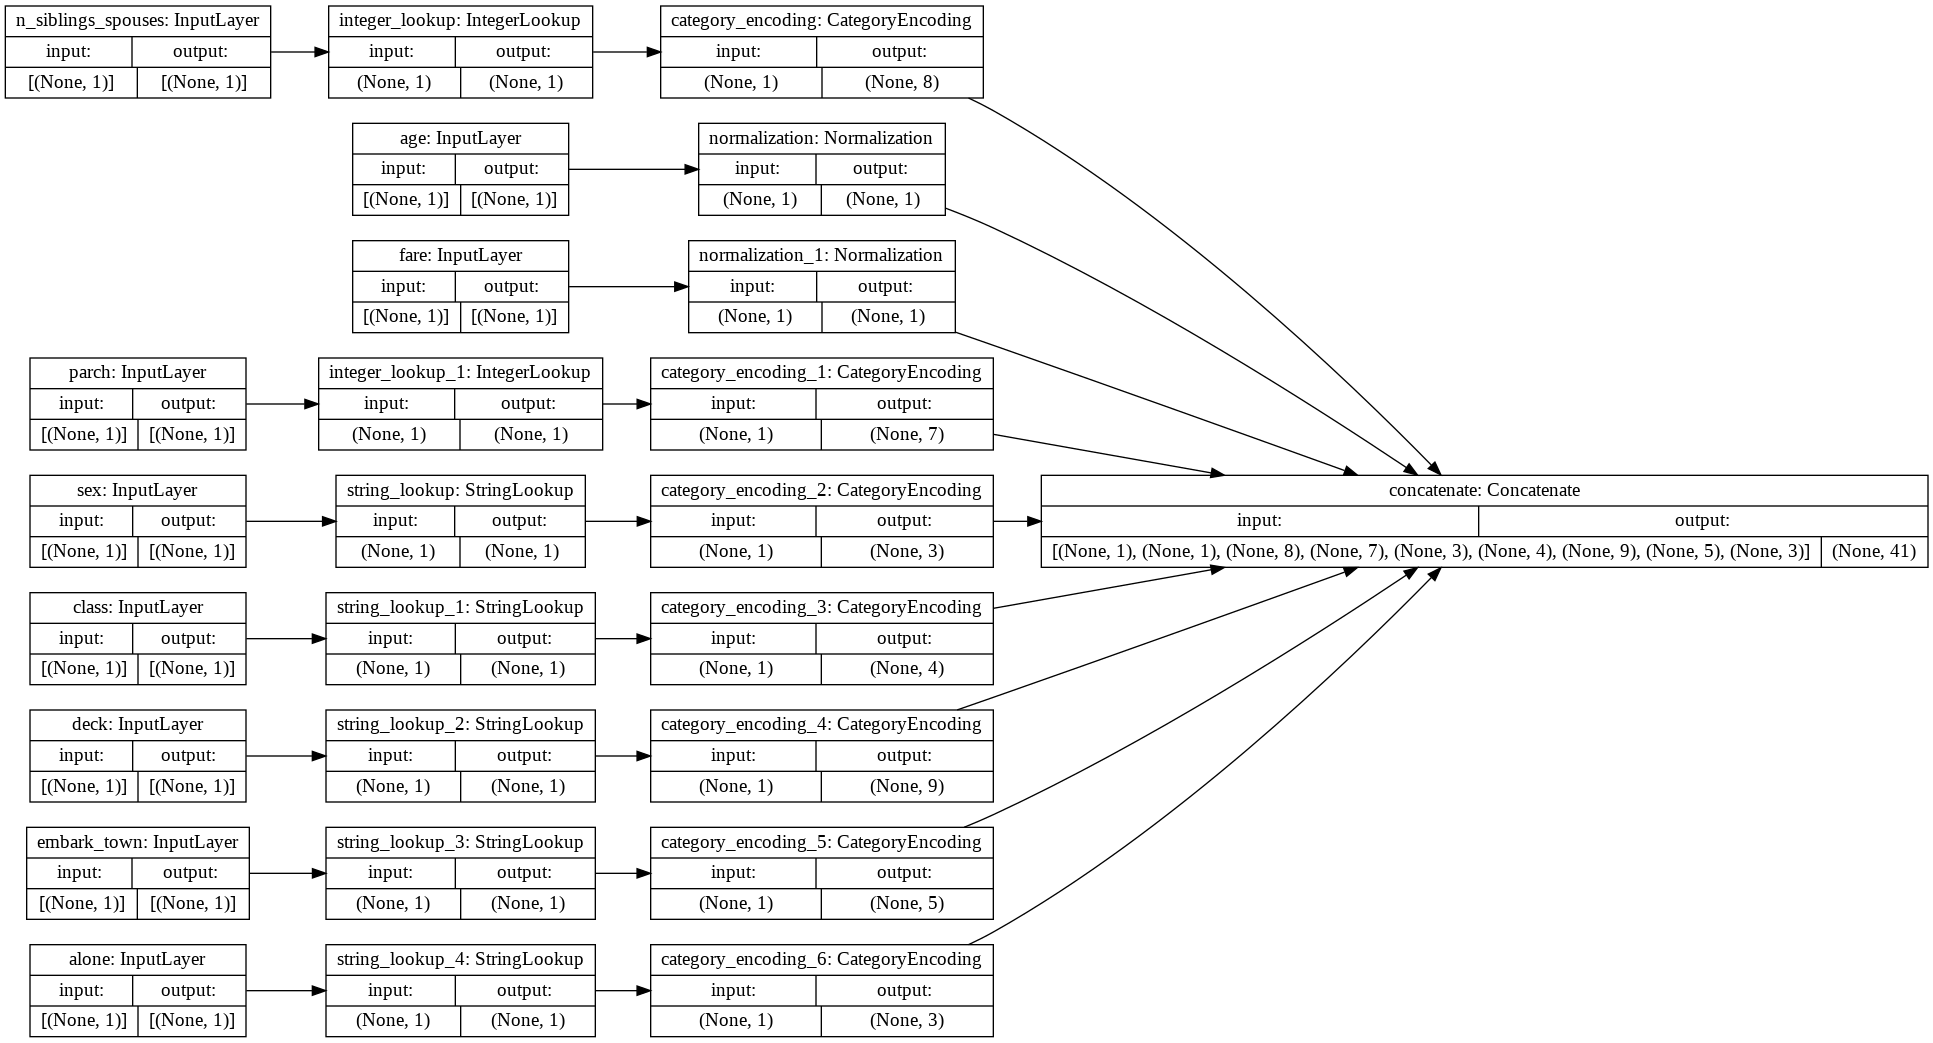

In [16]:
# lets plot the preprocessing 
tf.keras.utils.plot_model(titanic_preprocessing_model, show_shapes=True, rankdir='LR')

In [17]:
# titanic model

def build_hidden_layers(num_layers, num_units, activation_fn, out_units, dropout_rate):
  model = tf.keras.Sequential()
  for i in range(num_layers):
    model.add(tf.keras.layers.Dense(num_units, activation= activation_fn))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
  model.add(tf.keras.layers.Dense(out_units))
  return model

def titanic_model_builder(preprocessing=titanic_preprocessing_model, hidden_layers = build_hidden_layers(1,32,'relu', 1, 0.5), inputs=all_inputs):
  titanic_preprocessed = preprocessing(inputs)
  result = hidden_layers(titanic_preprocessed)
  model = tf.keras.Model(inputs, result)
  return model

In [18]:
# titanic model
titanic_model = titanic_model_builder()
# compile the model
titanic_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [19]:
titanic_history = titanic_model.fit(titanic_feature_ds_optimized, epochs=10)

Epoch 1/10
20/20 [==============================] - 1s 2ms/step - loss: 0.6924 - accuracy: 0.6013
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6321 - accuracy: 0.6284
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.6507
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6080 - accuracy: 0.6523
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5824 - accuracy: 0.6539
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5562 - accuracy: 0.6619
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5375 - accuracy: 0.6890
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5281 - accuracy: 0.6938
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5214 - accuracy: 0.7065
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4946 - accuracy: 0.7289


Since the preprocessing is part of the model, you can save the model and reload it somewhere else and get identical results:

In [20]:
# saving titanic model
titanic_model.save('test')
# reloading titanic model
reloaded = tf.keras.models.load_model('test')

INFO:tensorflow:Assets written to: test/assets


In [21]:
sample_data =  {k:v[:1] for k,v in titanic_feature_dict.items()}

In [22]:
sample_data

{'age': array([22.]),
 'alone': array(['n'], dtype=object),
 'class': array(['Third'], dtype=object),
 'deck': array(['unknown'], dtype=object),
 'embark_town': array(['Southampton'], dtype=object),
 'fare': array([7.25]),
 'n_siblings_spouses': array([1]),
 'parch': array([0]),
 'sex': array(['male'], dtype=object)}

In [23]:
sample_label = titanic_labels[0]
print('True label',sample_label)

True label 0


In [24]:
before = titanic_model(sample_data)

In [25]:
after = reloaded(sample_data)

In [26]:
assert (before-after) < 1e-3

In [27]:
print(before)

tf.Tensor([[-1.1484053]], shape=(1, 1), dtype=float32)


In [28]:
print(after)

tf.Tensor([[-1.1484053]], shape=(1, 1), dtype=float32)


In [29]:
model_prediction = tf.nn.sigmoid(before)
print(f'Model predict survival rate {model_prediction.numpy()[0][0]*100 :.2f}%')

Model predict survival rate 24.08%


## From a single file
So far we worked with `in-memory data`. **tf.data** is a highly scalable toolkit for building data pipelines, and provides a few functions for dealing loading CSV files.



In [30]:
url = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
titanic_file_path = tf.keras.utils.get_file(fname='train.csv', origin=url)
print('titanic file path :',titanic_file_path)

40960/30874 [=======================================] - 0s 0us/step
titanic file path : /root/.keras/datasets/train.csv


In [31]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(titanic_file_path,
                                                       batch_size=32,
                                                       label_name='survived',
                                                       num_epochs=1,
                                                       ignore_errors=True)

In [32]:
batch_features, batch_labels = next(iter(titanic_csv_ds))

for key, val in batch_features.items():
  print(f'{key :20} {val[0]}')
  

sex                  b'female'
age                  52.0
n_siblings_spouses   1
parch                1
fare                 93.5
class                b'First'
deck                 b'B'
embark_town          b'Southampton'
alone                b'n'


In [33]:
# It can also decompress the data on the fly. Here's a gzipped CSV file containing the metro interstate traffic dataset
traffic_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz"

traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz', 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='.', cache_subdir='traffic')

417792/405373 [==============================] - 1s 1us/step


In [34]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.1 MB/s 


In [35]:
import tensorflow_addons as tfa

In [36]:
traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=32,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type="GZIP")

In [37]:
traffic_col_and_types = {}

for feat_dict, label in traffic_volume_csv_gz_ds:
  for k, v in feat_dict.items():
    print(f'{k :20} {v[:1]} {v.dtype}')

    traffic_col_and_types[k] = v.dtype

  # Parse an input string according to the provided format string into a Unix time,
  # the number of seconds / milliseconds / microseconds / nanoseconds elapsed since January 1, 1970 UTC.
  print('INPUT time string ',str(feat_dict['date_time'][:1].numpy()[0]))
  date_obj_ = tfa.text.parse_time(feat_dict['date_time'][:1].numpy()[0],"%Y-%m-%d %H:%M:%S", 'SECOND' )
  print('OUTPUT unix time',date_obj_)
  break


holiday              [b'None'] <dtype: 'string'>
temp                 [293.27] <dtype: 'float32'>
rain_1h              [0.] <dtype: 'float32'>
snow_1h              [0.] <dtype: 'float32'>
clouds_all           [90] <dtype: 'int32'>
weather_main         [b'Clouds'] <dtype: 'string'>
weather_description  [b'overcast clouds'] <dtype: 'string'>
date_time            [b'2013-05-20 04:00:00'] <dtype: 'string'>
INPUT time string  b'2013-05-20 04:00:00'
OUTPUT unix time tf.Tensor(1369022400, shape=(), dtype=int64)


In [38]:
# column names and dtype
traffic_col_and_types

{'clouds_all': tf.int32,
 'date_time': tf.string,
 'holiday': tf.string,
 'rain_1h': tf.float32,
 'snow_1h': tf.float32,
 'temp': tf.float32,
 'weather_description': tf.string,
 'weather_main': tf.string}

In [39]:
# create  inputs   "symbolic" tensors.
traffic_inputs = {}
for k,v in traffic_col_and_types.items():
  input_ = tf.keras.Input(shape=(1,), name=k, dtype=v)
  traffic_inputs[k]=input_

traffic_inputs

{'clouds_all': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'clouds_all')>,
 'date_time': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'date_time')>,
 'holiday': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'holiday')>,
 'rain_1h': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'rain_1h')>,
 'snow_1h': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'snow_1h')>,
 'temp': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'temp')>,
 'weather_description': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'weather_description')>,
 'weather_main': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'weather_main')>}

In [40]:
# numerical data encoding
def traffic_numerical_encoding(feature, feature_name, dataset):
  feature_ds = dataset.map(lambda x,y: x[feature_name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
  # normalizer
  normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
  normalizer.adapt(feature_ds)
  return normalizer(feature)

# string/integer category encoding
def traffic_cat_encoding(feature, feature_name, dataset, is_string):
  feature_ds = dataset.map(lambda x,y: x[feature_name])
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
  # lookup class
  lookup = tf.keras.layers.experimental.preprocessing.StringLookup() if is_string else tf.keras.layers.experimental.preprocessing.IntegerLookup()
  lookup.adapt(feature_ds)
  indices = lookup(feature)
  return tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=lookup.vocabulary_size())(indices)
  
# date encoding
def traffice_date_encoding(feature, feature_name, dataset):
  feature_ds = dataset.map(lambda x,y: x[feature_name])
  feature_ds = feature_ds.map(lambda x: tfa.text.parse_time(x ,"%Y-%m-%d %H:%M:%S", 'SECOND' ))
  feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
  
  normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
  normalizer.adapt(feature_ds)

  return normalizer(tfa.text.parse_time(feature, "%Y-%m-%d %H:%M:%S", 'SECOND' ))
  

In [41]:
encoded_inputs = {}

for k, v in traffic_col_and_types.items():
  if v == tf.int32 or v == tf.float32:
    encoded_inputs[k] = traffic_numerical_encoding(feature=traffic_inputs[k], feature_name=k, dataset=traffic_volume_csv_gz_ds)

  if k != 'date_time' and v == tf.string:
    encoded_inputs[k] = traffic_cat_encoding(feature=traffic_inputs[k], feature_name=k, dataset=traffic_volume_csv_gz_ds, is_string=True)
  
  if k == 'date_time':
    encoded_inputs[k] = traffice_date_encoding(feature=traffic_inputs[k], feature_name=k, dataset=traffic_volume_csv_gz_ds)
    
encoded_inputs

{'clouds_all': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
 'date_time': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>,
 'holiday': <KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'category_encoding_7')>,
 'rain_1h': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 'snow_1h': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 'temp': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 'weather_description': <KerasTensor: shape=(None, 39) dtype=float32 (created by layer 'category_encoding_9')>,
 'weather_main': <KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'category_encoding_8')>}

In [42]:
# data preprocessing 
prep = tf.keras.layers.Concatenate()(list(encoded_inputs.values()))
traffic_preprocessing_model = tf.keras.Model(traffic_inputs, prep)

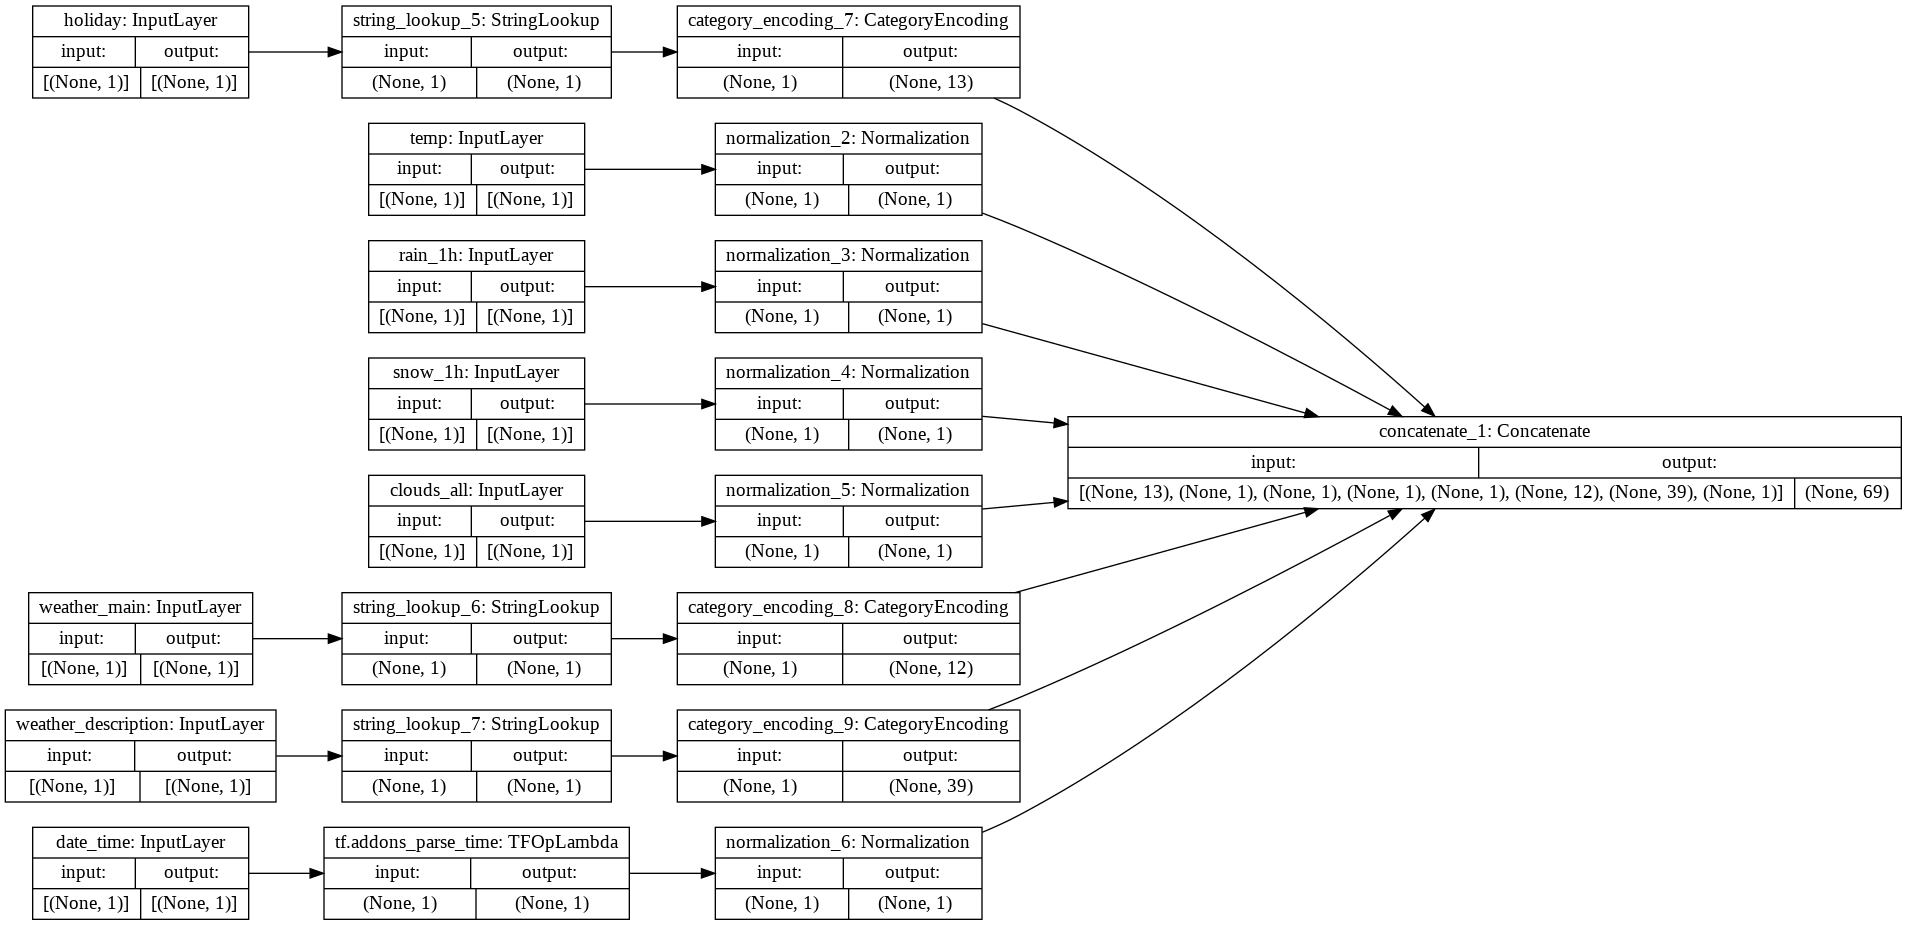

In [43]:
# visualize preprocessing
tf.keras.utils.plot_model(traffic_preprocessing_model, show_shapes=True, rankdir='LR')

In [44]:
# building a model 

traffic_body = tf.keras.Sequential([
                                     tf.keras.layers.Dense(32, activation='relu'),
                                     tf.keras.layers.Dense(1, activation='relu')
])

def traffic_model_builder(preprocessing,modeling,inputs):
  prep = preprocessing(inputs)
  result = modeling(prep)
  model = tf.keras.Model(inputs, result)

  # compile
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
  return model


In [45]:
# traffic model
traffic_model = traffic_model_builder(traffic_preprocessing_model, traffic_body, traffic_inputs)

In [46]:
# training the model
traffic_history = traffic_model.fit(traffic_volume_csv_gz_ds, epochs=10)

Epoch 1/10
1507/1507 [==============================] - 4s 2ms/step - loss: 13704155.0000 - mse: 13704155.0000
Epoch 2/10
1507/1507 [==============================] - 3s 2ms/step - loss: 9926682.0000 - mse: 9926682.0000
Epoch 3/10
1507/1507 [==============================] - 3s 2ms/step - loss: 6083713.0000 - mse: 6083713.0000
Epoch 4/10
1507/1507 [==============================] - 3s 2ms/step - loss: 4213307.5000 - mse: 4213307.5000
Epoch 5/10
1507/1507 [==============================] - 3s 2ms/step - loss: 3837941.0000 - mse: 3837941.0000
Epoch 6/10
1507/1507 [==============================] - 3s 2ms/step - loss: 3802347.7500 - mse: 3802347.7500
Epoch 7/10
1507/1507 [==============================] - 3s 2ms/step - loss: 3791299.5000 - mse: 3791299.5000
Epoch 8/10
1507/1507 [==============================] - 3s 2ms/step - loss: 3784459.2500 - mse: 3784459.2500
Epoch 9/10
1507/1507 [==============================] - 3s 2ms/step - loss: 3779886.7500 - mse: 3779886.7500
Epoch 10/10
1507/

## Caching

There is some overhead to parsing the csv data. For small models this can be the bottleneck in training.

Depending on your use case it may be a good idea to use Dataset.cache or data.experimental.snapshot so that the csv data is only parsed on the first epoch.

**The main difference between the cache and snapshot methods is that cache files can only be used by the TensorFlow process that created them, but snapshot files can be read by other processes.**

Note: snapshot files are meant for temporary storage of a dataset while in use. This is not a format for long term storage. The file format is considered an internal detail, and not guaranteed between TensorFlow versions.

If your data loading is slowed by loading csv files, and cache and snapshot are insufficient for your use case, consider re-encoding your data into a more streamlined format.

In [47]:
# lets see the effect of caching 

%%time
for i, (feature, label) in enumerate(traffic_volume_csv_gz_ds.repeat(10)):
  if i%40 ==0:
    print('.', end='')


.........................................................................................................................................................................................................................................................................................................................................................................................CPU times: user 12.2 s, sys: 1.58 s, total: 13.8 s
Wall time: 10.2 s


In [48]:
%%time
# cached the dataset
cached = traffic_volume_csv_gz_ds.cache().shuffle(1000)
# now iterate over the dataset

for i, (feature, label) in enumerate(cached.repeat(10)):
  if i%40 == 0:
    print('.', end='')


.........................................................................................................................................................................................................................................................................................................................................................................................CPU times: user 3.82 s, sys: 182 ms, total: 4.01 s
Wall time: 3.57 s


**Note: `Dataset.cache` stores the data form the first epoch and replays it in order. So using `.cache` disables any shuffles earlier in the pipeline. so the .shuffle is added back in after `.cache`.**
## Multiple files
One place where `tf.data` can really simplify things is when dealing with collections of files.

For example, the character font images dataset is distributed as a collection of csv files, one per font.

In [49]:
# downloading the data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip"

fonts_path = tf.keras.utils.get_file(fname='fonts.zip', origin=url, extract=True, cache_dir='.', cache_subdir='fonts')

160325632/160313983 [==============================] - 9s 0us/step


In [50]:
font_dir = pathlib.Path(fonts_path).parent
for i, dir in enumerate(font_dir.iterdir()):
  print(dir)
  if i==5:
    print('.....')
    break

fonts/SEGOE.csv
fonts/COMIC.csv
fonts/EUROROMAN.csv
fonts/STENCIL.csv
fonts/VLADIMIR.csv
fonts/BUXTON.csv
.....


In [51]:
font_csvs = []
for c in font_dir.glob('*.csv'):
  font_csvs.append(c)

print('Length :',len(font_csvs))

Length : 153


In [52]:
fonts_ds = tf.data.experimental.make_csv_dataset(file_pattern='fonts/*.csv',
                                                 batch_size=32,
                                                 num_epochs=1,
                                                 num_parallel_reads=tf.data.AUTOTUNE)

These csv files have the images flattened out into a single row. The column names are formatted `r{row}c{column}`. Here's the first batch:

In [53]:
feature = next(iter(fonts_ds))


for i,(k,v) in enumerate(feature.items()):
  print(f'{i} {k :15} {v[:1]}')
  if i == 15:
    print('................')
    break

0 font            [b'OCRA']
1 fontVariant     [b'scanned']
2 m_label         [53]
3 strength        [0.4]
4 italic          [0]
5 orientation     [0.]
6 m_top           [0]
7 m_left          [0]
8 originalH       [33]
9 originalW       [17]
10 h               [20]
11 w               [20]
12 r0c0            [1]
13 r0c1            [1]
14 r0c2            [1]
15 r0c3            [1]
................


Optional: Packing fields

You probably don't want to work with each pixel in separate columns like this. Before trying to use this dataset be sure to pack the pixels into an image-tensor.

Here is code that parses the column names to build images for each example:

In [73]:
feat_dict = {}
image =[None]*400
for i,(k,v) in enumerate(feature.items()):
  match = re.match(pattern='r(\d+)c(\d+)', string=k)
  if match:
    image[int(match.group(1))*20 + int(match.group(2))] = v
  else:
    feat_dict[k]=v 

In [100]:
feat_dict.keys()

dict_keys(['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'])

In [101]:
feat_dict['m_label']

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([  53,   90,   56,   48,   83,   65,   47,   62,   49,   83,   84,
         51,  104,   60,   48,   40,   64,   62,   84, 8482,   82,   77,
         43,   77,   54,   60,   40,   69,   49,   77,   48,   71],
      dtype=int32)>

In [106]:
for i in feat_dict['m_label']:
  print(chr(i), end=' ')

5 Z 8 0 S A / > 1 S T 3 h < 0 ( @ > T ™ R M + M 6 < ( E 1 M 0 G 

In [77]:
image[399]

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([  1, 255,   1,   1, 255, 255,   1,   1,   1, 255,   1,   1,   1,
       255,  83,  86,   1,   1,   1,   1, 255,   1,   0,   1, 255, 255,
         1,   1, 255, 101,   1, 255], dtype=int32)>

In [80]:
image =  tf.stack(image, axis=0)
image

<tf.Tensor: shape=(400, 32), dtype=int32, numpy=
array([[  1, 255,   1, ...,   1,   1,   1],
       [  1, 255,   1, ...,  94, 139,   1],
       [  1, 255,   1, ..., 161, 146,   1],
       ...,
       [  1, 255,  66, ..., 255,   1, 255],
       [  1, 255,   1, ..., 255,   1, 255],
       [  1, 255,   1, ..., 101,   1, 255]], dtype=int32)>

In [83]:
image = tf.reshape(image, (20,20,-1))
print(image.shape)

(20, 20, 32)


Text(0.5, 1.0, 'Z')

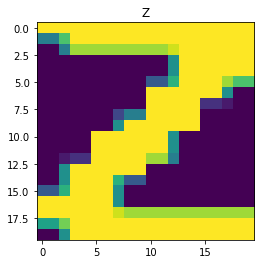

In [90]:
plt.imshow(image[...,1]);
plt.title(chr(feat_dict['m_label'][1]))

In [109]:
# lets create a utility

def pack_images_and_details(feature):
  feat_dict = {}
  image=[None]*400
  for k,v in feature.items():
    match = re.match('r(\d+)c(\d+)', k)
    if match:
      image[int(match.group(1))*20 + int(match.group(2))] = v
    else:
      feat_dict[k] = v
  image = tf.stack(image, axis=0)
  image = tf.reshape(image, shape=[20,20,-1])
  feat_dict['image'] = image
  return feat_dict


In [110]:
# Use map fn to pack the images 
packed_fonts_ds = fonts_ds.map(pack_images_and_details, num_parallel_calls=tf.data.AUTOTUNE)

In [111]:
fonts_feature_packed = next(iter(packed_fonts_ds))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10970 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10721 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 10970 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 10721 missing from current font.
  font.set_text(s, 0, flags=flags)


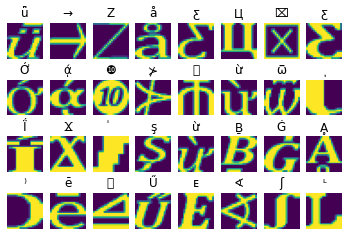

In [123]:
# ploting fonts 
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(fonts_feature_packed['image'][...,i])
  plt.axis('off')
  plt.title(chr(fonts_feature_packed['m_label'][i]))
plt.show()

## Lower level functions

`tf.io.decode_csv` - a function for parsing lines of text into a list of CSV column tensors.

`tf.data.experimental.CsvDataset` - a lower level csv dataset constructor.


### tf.io.decode_csv
This function decodes a string, or list of strings into a list of columns.

Unlike `make_csv_dataset` this function does not try to guess column data-types. You specify the column types by providing a list of record_defaults containing a value of the correct type, for each column

In [127]:
titanic_csv_url ="https://storage.googleapis.com/tf-datasets/titanic/train.csv"
titanic_file_path = tf.keras.utils.get_file(fname='train.csv', origin=url)
print('Titanic csv file path :', titanic_file_path)

Titanic csv file path : /root/.keras/datasets/train.csv


In [128]:
titanic_text = pathlib.Path(titanic_file_path).read_text()

In [131]:
titanic_lines = titanic_text.split(sep='\n')

In [136]:
titanic_lines[:3]

['survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone',
 '0,male,22.0,1,0,7.25,Third,unknown,Southampton,n',
 '1,female,38.0,1,0,71.2833,First,C,Cherbourg,n']

In [149]:
# data types 
all_strings = ['']*(titanic_lines[0].count(',')+1)

In [150]:
all_strings

['', '', '', '', '', '', '', '', '', '']

In [152]:
titanic_csv_build_1 = tf.io.decode_csv(records=titanic_lines[1:-1], record_defaults=all_strings)

In [158]:
for  feature in titanic_csv_build_1:
  print(feature.numpy()[0])

b'0'
b'male'
b'22.0'
b'1'
b'0'
b'7.25'
b'Third'
b'unknown'
b'Southampton'
b'n'


In [175]:
# tf.io.decode_csv - a function for parsing lines of text into a list of CSV column tensors.
for  feature in titanic_csv_build_1:
  print(feature.shape, feature.dtype)

(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>


In [162]:
# to parse the csv with actual type
titanic_types = [int(), str(), float(), int(), int(), float(), str(), str(), str(), str()]

titanic_csv_build_2 = tf.io.decode_csv(titanic_lines[1:-1], titanic_types)

for  feature in titanic_csv_build_2:
  print(feature.shape, feature.dtype)

(627,) <dtype: 'int32'>
(627,) <dtype: 'string'>
(627,) <dtype: 'float32'>
(627,) <dtype: 'int32'>
(627,) <dtype: 'int32'>
(627,) <dtype: 'float32'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>
(627,) <dtype: 'string'>


**Note: it is more efficient to call decode_csv on large batches of lines than on individual lines of csv text.**


**`tf.data.experimental.CsvDataset`**

The `tf.data.experimental.CsvDataset` class provides a minimal CSV Dataset interface without the convenience features of the `make_csv_dataset` function: column header parsing, column type-inference, automatic shuffling, file interleaving.

This constructor follows uses `record_defaults` the same way as `io.decode_csv`:

In [172]:
titanic_csv_build_3 = tf.data.experimental.CsvDataset(filenames=titanic_file_path, record_defaults=titanic_types, header=True)

for feature in titanic_csv_build_3:
  # feature -- tuple containing a titanic row data
  for col in feature:
    print(col.numpy())
  break

0
b'male'
22.0
1
0
7.25
b'Third'
b'unknown'
b'Southampton'
b'n'


In [177]:
# The above code is basically equivalent to:

def decode_titanic_line(line):
  return tf.io.decode_csv(line, titanic_types)

# load the lines of text
text = tf.data.TextLineDataset(titanic_file_path)
# skip the header
data = text.skip(1)
# decode
titanic_csv_build_4 = data.map(decode_titanic_line)


for feature in titanic_csv_build_4:
  # feature is tuple that has titanic row data
  for col in feature:
    print(col.numpy())
  break

0
b'male'
22.0
1
0
7.25
b'Third'
b'unknown'
b'Southampton'
b'n'


**Multiple files**

To parse the fonts dataset using `experimental.CsvDataset`, you first need to determine the column types for the record_defaults. 

In [181]:
font_lines = font_csvs[0].read_text().splitlines()

In [183]:
font_lines[1]

'SEGOE,SEGOE UI SEMILIGHT,65533,0.400000,0,0.000000,43,24,64,54,20,20,1,1,1,1,1,1,1,1,17,185,185,17,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,8,199,255,255,199,8,1,1,1,1,1,1,1,1,1,1,1,1,1,16,183,255,255,255,255,183,16,1,1,1,1,1,1,1,1,1,1,1,5,158,255,255,255,255,255,255,158,5,1,1,1,1,1,1,1,1,1,15,182,255,208,137,96,96,167,238,255,182,15,1,1,1,1,1,1,1,5,149,255,171,4,55,96,75,8,36,218,255,149,5,1,1,1,1,1,2,158,255,255,208,203,255,255,255,165,1,76,255,255,158,2,1,1,1,8,145,255,255,255,255,255,255,255,255,200,1,94,255,255,255,145,8,1,1,145,255,255,255,255,255,255,255,255,239,63,3,192,255,255,255,255,145,1,151,254,255,255,255,255,255,255,255,226,42,12,175,255,255,255,255,255,254,151,151,254,255,255,255,255,255,255,239,42,25,208,255,255,255,255,255,255,254,151,1,145,255,255,255,255,255,255,133,1,137,255,255,255,255,255,255,255,145,1,1,8,145,255,255,255,255,255,133,1,143,255,255,255,255,255,255,145,8,1,1,1,2,158,255,255,255,255,240,224,232,255,255,255,255,255,158,2,1,1,1,1,1,5,149,255,255,255,255,196,226

In [198]:
# we are adding two str field so substract one from the count 
font_types = [str(), str()]+[float()]*(font_lines[1].count(',')-1) 

In [207]:
print('length of type',len(font_types))

length of type 412


In [199]:
font_records = [str(p) for p in font_csvs]
font_csv_ds = tf.data.experimental.CsvDataset(font_records, record_defaults=font_types, header=True)

In [212]:
for feature in font_csv_ds:
  print('length of tuple',len(feature))
  for i,col in enumerate(feature):
    print(col)
    if i==5:
      break
  break

length of tuple 412
tf.Tensor(b'SEGOE', shape=(), dtype=string)
tf.Tensor(b'SEGOE UI SEMILIGHT', shape=(), dtype=string)
tf.Tensor(65533.0, shape=(), dtype=float32)
tf.Tensor(0.4, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


To interleave multiple files, use Dataset.interleave

In [221]:
font_list = tf.data.Dataset.list_files(os.path.dirname(fonts_path)+'/*.csv')

In [227]:
for i in list(font_list)[:5]:
  print(i.numpy())

print('\nlist_files - shuffles the file names each epoch:\n')
for i in list(font_list)[:5]:
  print(i.numpy())

b'./fonts/CAMBRIA.csv'
b'./fonts/TECHNIC.csv'
b'./fonts/MV_BOLI.csv'
b'./fonts/EDWARDIAN.csv'
b'./fonts/AGENCY.csv'

list_files - shuffles the file names each epoch:

b'./fonts/MATURA.csv'
b'./fonts/PALATINO.csv'
b'./fonts/HIMALAYA.csv'
b'./fonts/ENGLISH.csv'
b'./fonts/ERAS.csv'


The interleave method takes a map_func that creates a child-Dataset for each element of the parent-Dataset.

Here, you want to create a CsvDataset from each element of the dataset of files:

In [228]:
def create_dataset(csv_file):
  return tf.data.experimental.CsvDataset(filenames=csv_file, record_defaults=font_types, header=True)
  
# The Dataset returned by interleave returns elements by cycling over a number of the child-Datasets
fonts_csv_inter_ds = font_list.interleave(create_dataset, cycle_length=3, num_parallel_calls=tf.data.AUTOTUNE)

In [231]:
fonts_dict = {'font_name':[], 'character':[]}

for row in fonts_csv_inter_ds.take(5):
  fonts_dict['font_name'].append(row[0].numpy().decode())
  fonts_dict['character'].append(chr(row[2].numpy()))

fonts_df = pd.DataFrame(data=fonts_dict)
fonts_df.head()

,font_name,character
0,BERNARD,
1,HARLOW,
2,IMPACT,ﬄ
3,BERNARD,
4,HARLOW,


**Performance**

Earlier, it was noted that `io.decode_csv` is more efficient when run on a batch of strings.

It is possible to take advantage of this fact, when using large batch sizes, to improve CSV loading performance (but try caching first).

With the built-in loader 20, 2048-example batches take about 17s.

In [233]:
fonts_ds_1 = tf.data.experimental.make_csv_dataset(file_pattern=os.path.dirname(fonts_path)+'/*.csv',
                                                   batch_size=2048,
                                                   num_epochs=1,
                                                   num_parallel_reads=100)

In [234]:
%%time
for feature_batch in fonts_ds_1.take(20):
  print('.',end='')

....................CPU times: user 13.7 s, sys: 1.56 s, total: 15.3 s
Wall time: 20.9 s


In [237]:
font_file_list = tf.data.Dataset.list_files(os.path.dirname(fonts_path)+'/*.csv')
font_lines = font_file_list.interleave(map_func=lambda file: tf.data.TextLineDataset(file).skip(1),
                                       cycle_length=100,
                                       num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=2048)
fast_fonts = font_lines.map(lambda line:tf.io.decode_csv(records=line, record_defaults=font_types))

In [238]:
%%time
for feature_batch in fast_fonts.take(20):
  print('.',end='')

....................CPU times: user 6.51 s, sys: 249 ms, total: 6.76 s
Wall time: 3.9 s
